In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, precision_score, recall_score, accuracy_score
import numpy as np
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv("alzheimers_disease_data.csv")
df

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,6895,61,0,0,1,39.121757,0,1.561126,4.049964,6.555306,...,0,0,4.492838,1,0,0,0,0,1,XXXConfid
2145,6896,75,0,0,2,17.857903,0,18.767261,1.360667,2.904662,...,0,1,9.204952,0,0,0,0,0,1,XXXConfid
2146,6897,77,0,0,1,15.476479,0,4.594670,9.886002,8.120025,...,0,0,5.036334,0,0,0,0,0,1,XXXConfid
2147,6898,78,1,3,1,15.299911,0,8.674505,6.354282,1.263427,...,0,0,3.785399,0,0,0,0,1,1,XXXConfid


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

In [4]:
alzheimer = df.drop(columns="DoctorInCharge")
alzheimer

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,6.045039,0,0,0.014691,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,6895,61,0,0,1,39.121757,0,1.561126,4.049964,6.555306,...,0.238667,0,0,4.492838,1,0,0,0,0,1
2145,6896,75,0,0,2,17.857903,0,18.767261,1.360667,2.904662,...,8.687480,0,1,9.204952,0,0,0,0,0,1
2146,6897,77,0,0,1,15.476479,0,4.594670,9.886002,8.120025,...,1.972137,0,0,5.036334,0,0,0,0,0,1
2147,6898,78,1,3,1,15.299911,0,8.674505,6.354282,1.263427,...,5.173891,0,0,3.785399,0,0,0,0,1,1


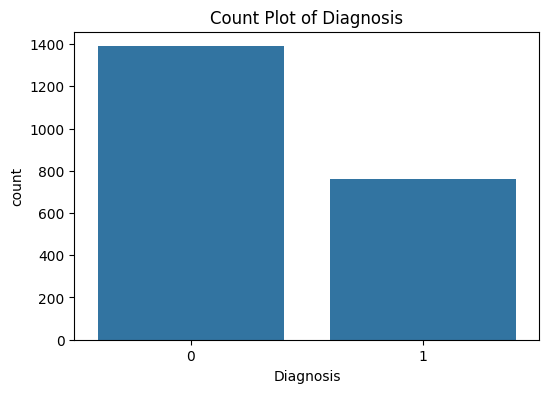

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x="Diagnosis", data=alzheimer)
plt.title("Count Plot of Diagnosis")
plt.show()

Coeficients:
	Age --> 0.0019217282769082788
	Gender --> 0.1383038392611655
	Ethnicity --> 0.007703054878469762
	EducationLevel --> -0.013328037401694224
	BMI --> 0.006065557147020274
	Smoking --> -0.2056679475349757
	AlcoholConsumption --> -0.005628354025241631
	PhysicalActivity --> -0.005336758047968777
	DietQuality --> 0.019583681082975098
	SleepQuality --> -0.05700379419231018
	FamilyHistoryAlzheimers --> -0.14314080161425013
	CardiovascularDisease --> 0.18174033275293444
	Diabetes --> 0.15415605743740268
	Depression --> -0.04640010958046241
	HeadInjury --> -0.3474405162340613
	Hypertension --> -0.05493732729486313
	SystolicBP --> 0.002126811151723849
	DiastolicBP --> 0.0047222303641899005
	CholesterolTotal --> 0.002969047275793812
	CholesterolLDL --> -0.0029512966735805645
	CholesterolHDL --> 0.008240957696878243
	CholesterolTriglycerides --> 0.0010488288790043237
	MMSE --> -0.10292459727381073
	FunctionalAssessment --> -0.44188901165595096
	MemoryComplaints --> 2.694869374417711
	

/home/elia/UNI/3r/1r semestre/Aprenentatge Computacional/APC/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


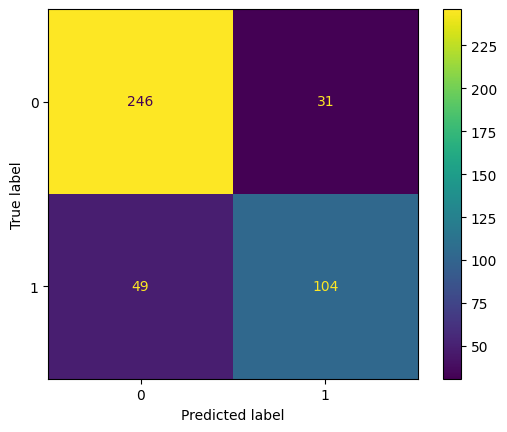

In [8]:
var = [c for c in alzheimer.columns if c not in ["Diagnosis", "PatientID"]]

target_variable = "Diagnosis"

X = alzheimer[var]
y = alzheimer[target_variable]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

print("Coeficients:")
for i in range(len(var)):
    print(f"\t{var[i]} --> {model.coef_[0][i]}")

y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print("\nMètriques del model:")
print(f"Accuracy:   {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall:     {rec:.3f}")
print(f"F1-score:   {f1:.3f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show() 


Coeficients:
	Age --> -0.0017948453211772957
	Gender --> 0.00728685229038214
	Ethnicity --> -0.007077320250472073
	EducationLevel --> -0.007002472560550503
	BMI --> -0.002589743871405292
	Smoking --> -0.029399909775322162
	AlcoholConsumption --> -0.008776407021889136
	PhysicalActivity --> 0.005204796495084528
	DietQuality --> 0.0011734101645254256
	SleepQuality --> -0.009492430480379855
	FamilyHistoryAlzheimers --> -0.017409754325315788
	CardiovascularDisease --> 0.009923292742147758
	Diabetes --> -0.0018729596930706263
	Depression --> -0.0027682767405791384
	HeadInjury --> -0.024664432549592476
	Hypertension --> 0.00822308717098463
	SystolicBP --> -5.5296814417767994e-05
	DiastolicBP --> 2.2898029968833662e-05
	CholesterolTotal --> 0.00011276491806176122
	CholesterolLDL --> -0.0004208864151780787
	CholesterolHDL --> 0.0007960767057379272
	CholesterolTriglycerides --> 9.350479041092282e-05
	MMSE --> -0.013111808972191705
	FunctionalAssessment --> -0.054442358721311514
	MemoryComplaints

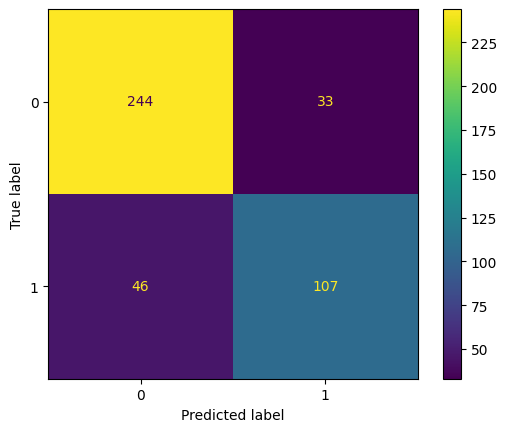

In [29]:
var = [c for c in alzheimer.columns if c not in ["Diagnosis", "PatientID"]]

target_variable = "Diagnosis"

X = alzheimer[var]
y = alzheimer[target_variable]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

model = Lasso(alpha=0.001).fit(X_train, y_train)


print("Coeficients:")
for i in range(len(var)):
    print(f"\t{var[i]} --> {model.coef_[i]}")


y_pred = model.predict(X_test)

y_pred = (y_pred >= 0.5).astype(int)


f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print("\nMètriques del model:")
print(f"Accuracy:   {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall:     {rec:.3f}")
print(f"F1-score:   {f1:.3f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show() 


Coeficients:
	Age --> 0.0014474251164318505
	Gender --> 0.12463258516421666
	Ethnicity --> -0.014007468366530215
	EducationLevel --> -0.01940967079049775
	BMI --> 0.02418937384718431
	Smoking --> -0.17698287116038253
	AlcoholConsumption --> -0.0037343028618425627
	PhysicalActivity --> 0.06544217653804013
	DietQuality --> 0.020217674925986542
	SleepQuality --> -0.049550582230494446
	FamilyHistoryAlzheimers --> -0.13074462571417844
	CardiovascularDisease --> 0.16297586566442723
	Diabetes --> 0.1517704840926996
	Depression --> -0.05397860828067666
	HeadInjury --> -0.32659834169963525
	Hypertension --> -0.04270886548301471
	SystolicBP --> 0.0015246225586106976
	DiastolicBP --> 0.0040585145647147195
	CholesterolTotal --> 0.0030498157903927074
	CholesterolLDL --> -0.0029861914064998464
	CholesterolHDL --> 0.008393035584931686
	CholesterolTriglycerides --> 0.0008950362588778189
	MMSE --> -0.10584114710251287
	FunctionalAssessment --> -0.43451757964096005
	MemoryComplaints --> 2.62852727590249

/home/elia/UNI/3r/1r semestre/Aprenentatge Computacional/APC/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


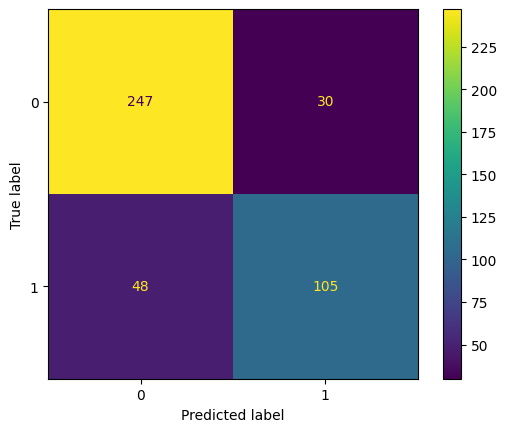

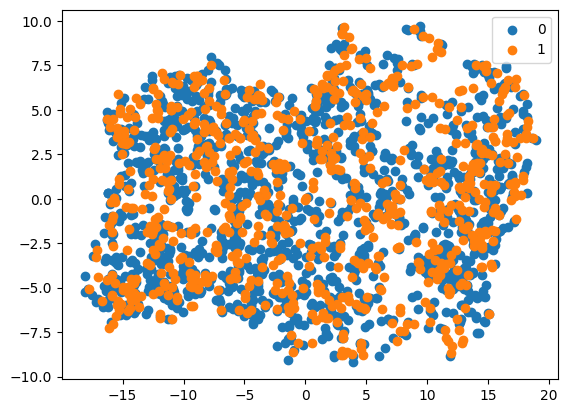

In [34]:
X = alzheimer[var]
y = alzheimer['Diagnosis']

X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', random_state=1).fit_transform(X)

for n in range(0, 2):
  idx = np.where(y == n)[0]
  plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=f"{n}")

plt.legend()
plt.show()

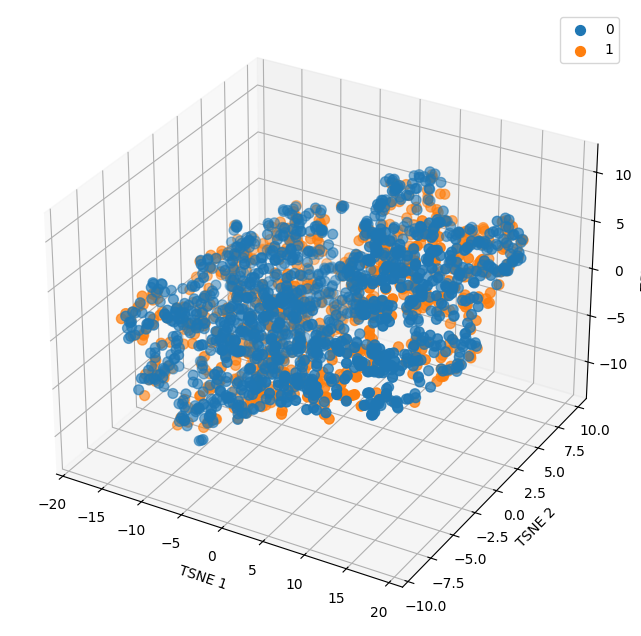

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

X = alzheimer[var]
y = alzheimer['Diagnosis']

# TSNE amb 3 components
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', random_state=1).fit_transform(X)

# Crear figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for n in range(0, 2):
    idx = np.where(y == n)[0]
    ax.scatter(X_embedded[idx, 0], X_embedded[idx, 1], X_embedded[idx, 2], label=f"{n}", s=50)

ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
ax.set_zlabel("TSNE 3")
ax.legend()

plt.show()

